In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.optimize import curve_fit
# import pylandau as pland
# import ROOT
import scipy.ndimage as ndimage
import numpy.ma as ma
from functions_MuonsNSAMP1 import *
from ROOT import TF1, TGraph

def gaussian(x, a, mean, sigma, y_move):
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2))) - y_move

# def gaussian(x, a, mean, sigma):
#     return a * np.exp(-((x - mean)**2 / (2 * sigma**2))) 

def diffution_curve(z, alpha, beta):
    return np.sqrt(np.abs(alpha * np.log(1 - (beta * z))))
    
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4, letter
from reportlab.lib.utils import ImageReader

In [2]:
import matplotlib.colors


plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth":2,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',

})

ColorMap = 'jet'
Norm = matplotlib.colors.LogNorm(vmin=10**-1, vmax=5 * 10**0)

In [3]:
# path = './Diccionarios_Espetro_Muones/dict_straight_muons_Extensions_1_to_4_Imgs_189_Elip_0.9_Sol_0.65_Skirts_0_NSIGMAS_13_KeV__NSAMP324.pkl'
# path = './Diccionarios_Espetro_Muones/dict_straight_muons_Extensions_1_to_4_Imgs_189_Elip_0.9_Sol_0.65_Skirts_0_NSIGMAS_20_KeV__NSAMP324.pkl'
path = './Diccionarios_Espetro_Muones/dict_muons_NSAMP324_Extensions_1_2_4_NIMGS_393_SOL_0.65_ELIP_0.65_NSIGMAS_13_DEDL_1400_SIZE_250x539_KeV_n.pkl'

histogram = open(path, 'rb')
data_histogram = pkl.load(histogram)
histogram.close()

#### Visualizar las keys del diccionario ####
print('Las unidades de los datos están en: ', data_histogram['Energy_Units'])
print('Llaves principales del diccionario: ', data_histogram.keys())
print('Llaves secuandarias por extensión: ', data_histogram['extension_1'].keys(), end='\n\n')
# print(type(data_histogram['extension_1']['all_events']))
# data_muons_extension_1 = data_histogram['extension_1']
# data_muons_extension_2 = data_histogram['extension_2']
# data_muons_extension_4 = data_histogram['extension_4']
Ext = 1

n_muons = data_histogram['All_Muons_Detected']
print('Se detectaron ', n_muons, ' muones (contando las 3 extensiones)')
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)

Las unidades de los datos están en:  2
Llaves principales del diccionario:  dict_keys(['Num_Images', 'All_Muons_Detected', 'Energy_Units', 'Elipticity', 'Solidity', 'Fit_errors', 'extension_1', 'extension_2', 'extension_4'])
Llaves secuandarias por extensión:  dict_keys(['charge', 'deltaEL', 'deltaL', 'all_events', 'theta', 'phi', 'gain', 'elip', 'sol', 'all_events_elip', 'all_events_sol', 'datamasked', 'run'])

Se detectaron  2833  muones (contando las 3 extensiones)


# Extension 1

## Cuadrante 1

### DataFrame y visualización

In [4]:
### Se crea el dataframe y se selecciona un rango de datos ###
Ext = 1
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)
# display(DF_muons[450:500])
list_newmatrix = []
list_indexs =[]
# range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(165, 195)]
range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(0, 90)]

# range_in_phi = range_in_phi[range_in_phi['Gain (ADU/e-)'].between(213, 217)]
for index in range_in_phi.index:
    # print(index)
    list_newmatrix.append(list_datamask[index])
    list_indexs.append(index)

print(list_indexs)
list_phi_ext1 = data_histogram['extension_' + str(Ext)]['phi']
list_mask_rot = []

list_listsnxny = []

for index in list_indexs[:]:
    datamask = list_datamask[index]
    ylen, xlen = datamask.shape
    list_nxny = []

    data_mask_zeros = np.empty((ylen + 90, xlen+50))
    data_mask_zeros[:] = 0
    ylen_zeros, xlen_zeros = data_mask_zeros.shape
    # print(data_mask_zeros.shape)
    
    ### Angle rot ##
    phi_rot = np.pi/2 - list_phi_ext1[index]
    # print(phi_rot, phi_rot + list_phi_ext1[index])

    # print('shape original: ', xlen, ylen)
    # print('shape zeros: ', xlen_zeros, ylen_zeros)

    for y_bin in range(0, ylen):
        for x_bin in range(0, xlen):
            if datamask[y_bin][x_bin] != 0:
                nx, ny = pixel_rot(x_bin=x_bin, x0=0, y_bin=y_bin, y0=0, theta= phi_rot)
                list_nxny.append((nx + 10, ny))
                # print(nx, ny)
                data_mask_zeros[ny][nx+10] = datamask[y_bin][x_bin]

    list_listsnxny.append(list_nxny)
    label_img, nlabels_img = sk.measure.label(data_mask_zeros > 0, connectivity=2, return_num=True)
    loc = nd.find_objects(label_img == 1)[0]
    mask_rot = np.invert(label_img==1)
    # data_mask_rot = ma.masked_array(data_mask_zeros, mask_rot)
    data_mask_rot = ma.masked_array(data_mask_zeros[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_rot[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

    list_mask_rot.append(data_mask_rot)
    # print('Shape rot: ', data_mask_rot.shape[1], data_mask_rot.shape[0])
    
    # plt.imshow(data_mask_rot)
    # plt.show()

# print(list_mask_rot)
#     

[0, 2, 3, 20, 24, 25, 28, 30, 32, 35, 36, 38, 41, 42, 43, 57, 61, 65, 74, 78, 81, 84, 85, 88, 95, 104, 106, 109, 115, 122, 126, 130, 132, 135, 140, 144, 145, 146, 151, 152, 153, 165, 167, 172, 184, 185, 187, 188, 189, 193, 213, 216, 217, 222, 224, 234, 238, 239, 244, 247, 249, 254, 261, 262, 263, 265, 266, 271, 275, 279, 283, 284, 292, 303, 315, 316, 320, 328, 332, 344, 345, 348, 351, 364, 369, 376, 379, 380, 381, 384, 389, 414, 426, 432, 436, 437, 440, 441, 444, 447, 449, 454, 457, 459, 464, 465, 469, 474, 475, 476, 478, 488, 499, 500, 503, 505, 512, 514, 515, 520, 524, 525, 527, 530, 531, 538, 544, 548, 552, 558, 559, 562, 572, 573, 580, 582, 585, 592, 595, 598, 602, 616, 620, 624, 630, 632, 636, 637, 639, 643, 644, 649, 654, 667, 668, 679, 682, 686, 691, 693, 695, 699, 702, 703, 711, 712, 713, 714, 718, 719, 732, 739, 741, 746, 751, 760, 768, 769, 771, 791, 792, 797, 799, 803, 804, 805, 808, 814, 815, 818, 823, 824, 825, 836, 843, 851, 857, 858, 860, 861, 863, 868, 869, 870, 872, 87

,date_run,Gain (ADU/e-),Solidity,Elipticity,Theta (Deg),Phi (Deg),Charge (KeV),l (cm),dEdL (KeV/cm)
Muon ID,,,,,,,,,
562,ENE2025,218.065185,0.706237,0.824479,45.77804,73.708948,272.198364,0.103952,2618.510083


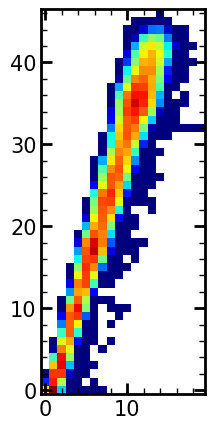

In [5]:
# list_muonlabels = [10, 15, 74, 91, 92, 112, 133, 176, 196, 256]  # Segunda revisión (están arriba)
# list_muonlabels = [10, 15, 91, 112, 176, 196, 256] # Tercera revisión (con misma gain = 215)

n_label = 562
display(DF_muons.iloc[[n_label]])

figure , axs = plt.subplots(1,1,figsize=[5,5])
# axs.imshow(list_mask_rot[n_label],  cmap = ColorMap, norm=Norm)  # 77, 1911, 2381, 2930 indices para path con elip 0.85, Sol 0.7
axs.imshow(list_datamask[n_label],  cmap = ColorMap, norm=Norm)  # 77, 1911, 2381, 2930 indices para path con elip 0.85, Sol 0.7
plt.show()


Numper of rows:  43
Long of line:  2


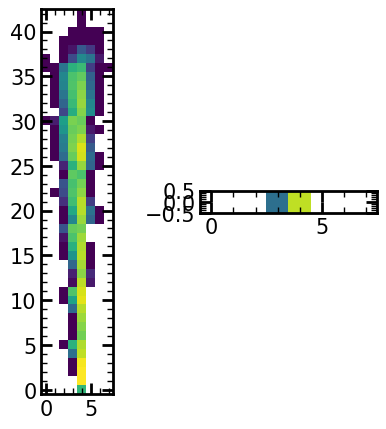

In [6]:
figure , axs = plt.subplots(1,2,figsize=[5,5])

label_muon = 0
label_line = 5
muon = list_mask_rot[label_muon]
print('Numper of rows: ', muon.shape[0])
line = list_mask_rot[label_muon][label_line - 1:label_line][0]

n_longline = 0
for pixel in line:
    if pixel != 0:
        # print(pixel)
        n_longline += 1

print('Long of line: ', n_longline)

axs[0].imshow(list_mask_rot[label_muon], norm = Norm)
axs[1].imshow(list_mask_rot[label_muon][label_line - 1:label_line], norm = Norm)
plt.show()

In [7]:
list_index_long_muons = []
extension = 1

for index in range(0, len(list_mask_rot)):
    size_x = list_mask_rot[index].shape[1]
    size_y = list_mask_rot[index].shape[0]
    if size_y > 50:
        # print(size_x, size_y)
        list_index_long_muons.append(index)

# print(list_index_long_muons)+
print('Muones largos detectados: ', len(list_index_long_muons))
print('Indices: ', list_index_long_muons)

Muones largos detectados:  52
Indices:  [1, 9, 10, 15, 16, 17, 22, 32, 38, 44, 49, 50, 54, 68, 73, 86, 87, 88, 95, 96, 104, 106, 107, 114, 117, 137, 144, 154, 155, 158, 159, 160, 169, 172, 180, 183, 186, 196, 197, 206, 207, 213, 214, 219, 221, 222, 228, 242, 243, 250, 252, 257]


### Perfil Energético

Number of rows:  54


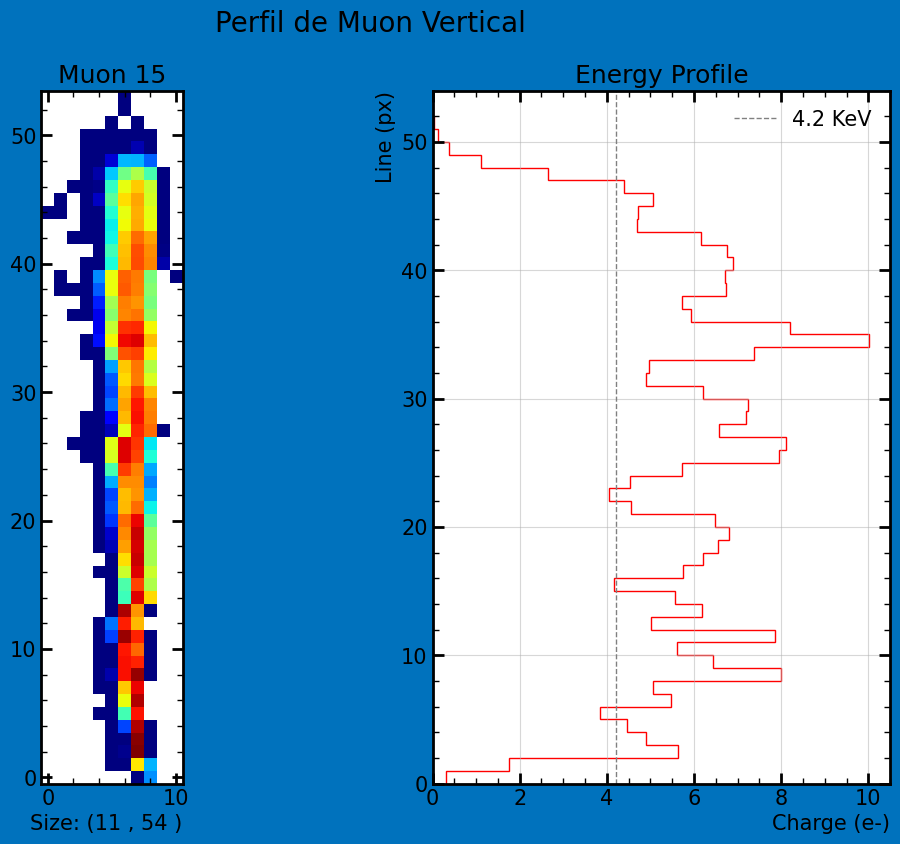

In [46]:
# list_muonlabels = [10, 15, 74, 91, 92, 112, 133, 176, 196, 256]  # Segunda revisión (están arriba)
muon_label = 15  # Se coloca directamente el label del evento

Delta_inicial = 0
Delta_final = 0
extension = 1

fig, axs = plt.subplots(ncols=2, nrows=1, figsize = [13,9], facecolor = [0, 0.4470, 0.7410])
fig.suptitle('Perfil de Muon Vertical', y = 0.97, size = 20)
event = list_mask_rot[muon_label]
# plt.imshow(event)

size_x = event.shape[1] # tamaño en x
size_y = event.shape[0] # tamaño en y
# print(event.sum())

print('Number of rows: ', event.shape[0])
charge_verticalMuon = []
for index in range(1, size_y):
    line = event[index - 1:index][0]
    charge = line.sum()
    charge_verticalMuon.append(charge)

        
# cmap = 'plasma'
axs[0].imshow(event, cmap = ColorMap, norm = Norm)#, origin='upper')
axs[0].set_title('Muon ' + str(muon_label))
axs[0].set_xlabel('Size: (' + str(size_x) + ' , ' + str(size_y) + ' )')
# x0bar = fig.colorbar(x0, ax=axs[0])

axs[1].stairs(charge_verticalMuon, range(0,len(charge_verticalMuon)+1),  orientation='horizontal', color = 'r')#,  hatch = '////')
axs[1].axvline(4.2, 0, size_y+2, linestyle='--', color='gray', label = '4.2 KeV')
# axs[1].vlines(x = mean_charge, ymin = 0, ymax = len(event) - 1, color = 'k', label = 'Mean Charge \n' + str(mean_charge))

axs[1].set_ylim(0, size_y)
# axs[1].set_xlim(0, 4000)


# axs[1].set_xlabel('Charge (KeV)')
axs[1].set_xlabel('Charge (e-)')
axs[1].set_ylabel('Line (px)')
# axs[1].set_ylim(0,len(event) - 1 )
axs[1].set_title('Energy Profile')
axs[1].legend()
axs[1].grid()
plt.show()

In [9]:
list_muonlabels = [10, 15, 74, 91, 92, 112, 133, 176, 196, 256]  # Segunda revisión (están arriba)

for muon_label in list_muonlabels:
    event = list_mask_rot[muon_label]
    print('Muon: ', muon_label, ', Shape (X, Y): ', event.shape[1], event.shape[0])

Muon:  10 , Shape (X, Y):  12 82
Muon:  15 , Shape (X, Y):  11 54
Muon:  74 , Shape (X, Y):  8 31
Muon:  91 , Shape (X, Y):  9 36
Muon:  92 , Shape (X, Y):  10 36
Muon:  112 , Shape (X, Y):  9 40
Muon:  133 , Shape (X, Y):  8 27
Muon:  176 , Shape (X, Y):  8 41
Muon:  196 , Shape (X, Y):  8 74
Muon:  256 , Shape (X, Y):  12 43


### Modelo de Difusión

In [10]:
CCD_depth = 725 # micras
Delta_inicial = 3    # px
Delta_final = 6     # px
Bins = 50

extension = 1
label_muon = 1
lable_line = 12
img_sigma = 0.0003  # KeV 
# print(img_sigma)

## Se checa si el muon tiene la orientación correcta
event = list_mask_rot[label_muon]
size_x = event.shape[1]
size_y = event.shape[0]

# lines = 0
Longitud_XY = size_y 
Longitud_linea = size_x

Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)


line = event[lable_line - 1:lable_line][0]
Carga_renglon = line.sum()
Mean_carga = np.mean(line)


Mean_in  = 0
var = 0
carga_cuadrada = 0

### Se calcula el X promedio ##
for pixel in np.arange(0, Longitud_linea, 1):
    if line[pixel]:
        element_pixel = (pixel * line[pixel]) / Carga_renglon
        Mean_in = Mean_in + element_pixel
    else:
        element_pixel = 0
    
    Mean_in = Mean_in + element_pixel

## Calcula la suma de las cargas al cuadrado ##
for pixel in np.arange(0, Longitud_linea, 1):
    if line[pixel]:
        element_pixel = line[pixel]**2
    else:
        element_pixel = 0

    carga_cuadrada = carga_cuadrada + element_pixel 

Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

### Se calcula la varianza ##
for pixel in np.arange(0, Longitud_linea, 1):
    element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2
    var = var + element_pixel  ### COreggir la varianza con otro estimados

### Se corrige la varianza con la carga ###
var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))

### Se calcula la sigma ###
sigma_in = np.sqrt(var)
# sigma_in = np.sqrt(var_true)


##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
list_xlabel = np.arange(0.5, len(line), 1)

# list_xlabel_long = np.linspace(-Longitud_linea + int(Longitud_linea/2) , Longitud_linea + int(Longitud_linea/2), Longitud_linea)

# popt, pcov = curve_fit(gaussian, list_xlabel, data_mask[0], maxfev=100000, p0 = [8000, Mean_in, sigma_in])		# Fit histogram with gaussian

print('Lonitud de la linea: ', len(line.flatten()))

## Ajuste gaussiano con ROOT ##
fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

for index in range(0, len(line)):
    if line[index] != 0:
        # print(index, line[index])
        h3.SetBinContent( index + 1, line[index])
        h3.SetBinError(index + 1, img_sigma)
        # h3.SetBinError(index + 1, 0.001)
        #print(pixel_value)

fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h3.Fit(fgaus2, "RQN")

fit_const = fgaus2.GetParameters()[0]
fit_mean = fgaus2.GetParameters()[1]
fit_sigma = fgaus2.GetParameters()[2]
print('Sigma fit: ', fit_sigma, end='\n\n')

c3=TCanvas()

h3.Draw()
c3.Draw()
fgaus2.Draw("same")
# gStyle.SetOptFit(1100)
# gStyle.SetPadGridX (True)



# plt.show()

Lonitud de la linea:  9
Sigma fit:  0.33574934378252685



/tmp/ipykernel_10433/2283610798.py:149: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs_all.legend()


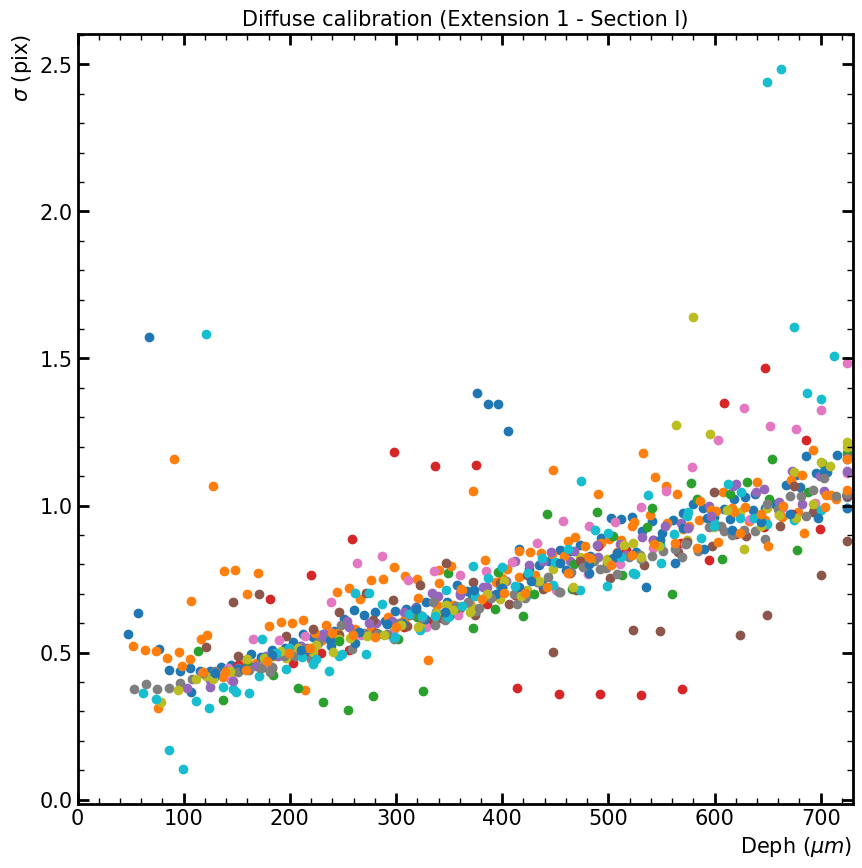

In [ ]:
CCD_depth = 725 # micras
Delta_inicial = 5    # px
Delta_final = 6     # px
Bins = 50

extension = 1
label_muon = 1
img_sigma = 0.0008  # KeV 
# print(img_sigma)
fig, axs_all = plt.subplots(figsize = [10,10])

# list_muonlabels = []
# for index in range(0, len(list_mask_rot)):
#     list_muonlabels.append(index)

# list_muonlabels = [10, 15, 30, 39, 47, 61, 74, 77, 91, 92, 112, 117, 133, 157, 176, 184, 189, 196, 213, 214, 231, 256, 0, 1, 8, 9, 14,16,18,25,32, 
#                    35, 44, 45, 46, 50, 70, 73, 82, 88, 105, 127, 141, 146, 151, 164, 165, 169, 174, 180, 183, 220, 222, 242, 243, 252]

# list_muonlabels = [10, 15, 0, 1]

# list_muonlabels = [0, 1, 8, 9, 14,16,18,25,32, 35, 44, 45, 46, 50, 70, 73, 82, 88, 105, 127, 141, 146, 151, 164, 165, 169, 174, 180, 183, 220, 222, 242, 243, 252]  # Primeros sacados a ojo (están abajo)
# list_muonlabels = [8, 14,18,25, 32, 70, 88, 151, 165, 174, 180, 183, 222]  # Segunda revisión (están abajo)
# list_muonlabels = [18,25, 70, 88, 151, 174, 180]  # Tercera revisión (están abajo)
# list_muonlabels = [25, 88, 151, 180]  # Tercera revisión (están abajo)

 
list_muonlabels = [10, 15, 30, 39, 47, 61, 74, 77, 91, 92, 112, 117, 133, 157, 176, 184, 189, 196, 213, 214, 231, 256]  # Primeros sacados a ojo (están arriba)
# list_muonlabels = [10, 74, 91, 92, 112, 133, 176, 196, 256]  # Segunda revisión (están arriba)
# list_muonlabels = [10, 15, 91, 112, 176, 196, 256]  # Tercera revisión con, mas o menos, misma gain (están arriba)
# list_muonlabels = [91, 112, 196, 256]  # Cuarta revisión, este es el mejor hasta el momento
# list_muonlabels = [91, 196]  # Quinta revisión, para que se ajuste mejor (están arriba)



# list_muonlabels = [256, 257, 258]



for label_muon in list_muonlabels: 
    event = list_mask_rot[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_y 
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []
    for lable_line in range(Delta_inicial, size_y - Delta_final):
        line = event[lable_line - 1:lable_line][0]
        Carga_renglon = line.sum()
        Mean_carga = np.mean(line)
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel]:
                element_pixel = (pixel * line[pixel]) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel = line[pixel]**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel]
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        # var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var_true)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

        for index in range(0, len(line)):
            if line[index] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index])
                h3.SetBinError(index + 1, img_sigma)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQN")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)

    # axs_all.scatter(list_deep, list_fitsigmas, label = 'Muon: ' + str(label_muon))
    axs_all.scatter(list_deep, list_fitsigmas)


def diffution_curve(z, alpha, beta):
    return np.sqrt((alpha * np.log(1 - (beta * z))))

fit_range = np.arange(0, 725)

# axs_all.plot(fit_range, diffution_curve(fit_range, alpha=-200, beta=0.001) / 15, '--r', linewidth = 3)

axs_all.set_title('Diffuse calibration (Extension 1 - Section I)', size = 15)#, y=0.92)}
axs_all.set_ylabel(r'$\sigma$ (pix)')
axs_all.set_xlabel(r'Deph ($\mu m$)')
# axs_all.set_ylim(0, 1.5)
axs_all.set_xlim(0, 730)
axs_all.legend()
axs_all.grid
plt.show()

In [41]:
# for n_label in list_muonlabels:
#     display(DF_muons.iloc[[n_label]])

/tmp/ipykernel_10433/3828115749.py:138: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs_all.legend()


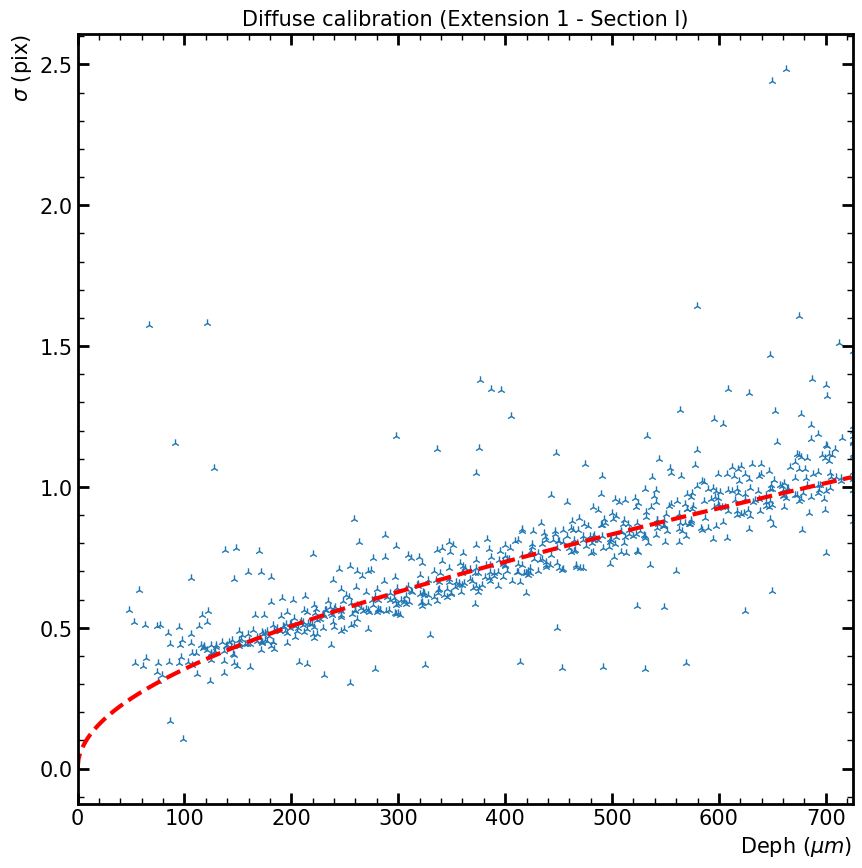

In [42]:
img_sigma = 0.0008  # KeV 
# print(img_sigma)
fig, axs_all = plt.subplots(figsize = [10,10])

# list_muonlabels = [256, 257, 258]

list_all_sigmas = []
list_all_deeps = []

for label_muon in list_muonlabels: 
    event = list_mask_rot[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_y 
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []

    for lable_line in range(Delta_inicial, size_y - Delta_final):
        line = event[lable_line - 1:lable_line][0]
        Carga_renglon = line.sum()
        Mean_carga = np.mean(line)
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel]:
                element_pixel = (pixel * line[pixel]) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel = line[pixel]**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel]
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        # var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

        for index in range(0, len(line)):
            if line[index] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index])
                h3.SetBinError(index + 1, img_sigma)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQN")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)


    for index in range(0, len(list_fitsigmas)):
        list_all_sigmas.append(list_fitsigmas[index])
        list_all_deeps.append(list_deep[index])

    # axs_all.scatter(list_deep, list_fitsigmas, marker='2', label = 'Muon: ' + str(label_muon))
del list_fitsigmas
del list_deep


fit_range = np.arange(0, 725)



axs_all.scatter(list_all_deeps, list_all_sigmas, marker='2')

def diffution_curve(x, alpha, beta):
    return np.sqrt((alpha * np.log(1 - (beta * x))))

# popt_DM, _ = curve_fit(diffution_curve, list_all_deeps, list_all_sigmas, maxfev=100000, p0= [1, 1])
# dict_diffution_model = {'Alpha' : popt_DM[0], 'Beta' : popt_DM[1]}
# print('Alpha: ', dict_diffution_model['Alpha'], ' Beta: ', dict_diffution_model['Beta'])




axs_all.plot(fit_range, diffution_curve(fit_range, -611, 0.00045)/15, '--r', linewidth = 3)

axs_all.set_title('Diffuse calibration (Extension 1 - Section I)', size = 15)#, y=0.92)}
axs_all.set_ylabel(r'$\sigma$ (pix)')
axs_all.set_xlabel(r'Deph ($\mu m$)')
# axs_all.set_ylim(0, 1.5)
axs_all.set_xlim(0, 725)
axs_all.legend()
axs_all.grid
plt.show()

In [43]:
list_all_sigmas = []
list_all_deeps = []

for label_muon in list_muonlabels: 
    event = list_mask_rot[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_y 
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []

    for lable_line in range(Delta_inicial, size_y - Delta_final):
        line = event[lable_line - 1:lable_line][0]
        Carga_renglon = line.sum()
        Mean_carga = np.mean(line)
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel]:
                element_pixel = (pixel * line[pixel]) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel = line[pixel]**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel]
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        # var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

        for index in range(0, len(line)):
            if line[index] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index])
                h3.SetBinError(index + 1, img_sigma)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQN")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)


    for index in range(0, len(list_fitsigmas)):
        list_all_sigmas.append(list_fitsigmas[index])
        list_all_deeps.append(list_deep[index])

    # axs_all.scatter(list_deep, list_fitsigmas, marker='2', label = 'Muon: ' + str(label_muon))
del list_fitsigmas
del list_deep



# fit_range = np.arange(0, 900)
# axs_all.scatter(list_all_deeps, list_all_sigmas, marker='2')
 
h_model = TGraph(len(list_all_sigmas), np.array(list_all_deeps),np.array(list_all_sigmas))
h_model.SetMarkerStyle(2) # Set marker style (e.g., solid circle)
h_model.SetName("Data")
h_model.SetStats()



Range_fit = [0, 725]
diff_curve = TF1("diff_curve", "sqrt(([0] * log(1 - [1]*x)))/15", Range_fit[0], Range_fit[1], 2) #np.sqrt(np.abs(alpha * np.log(1 - (beta * z))))

diff_curve.SetParameters(-200, 0.00001) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h_model.Fit(diff_curve, "RNQ")

fit_alpha = diff_curve.GetParameters()[0]
fit_beta = diff_curve.GetParameters()[1]
chi2 = diff_curve.GetChisquare()
ndf = diff_curve.GetNDF()
prob = diff_curve.GetProb()

fit_alpha_err = diff_curve.GetParErrors()[0]
fit_beta_err = diff_curve.GetParErrors()[1]

print('Alpha: ', fit_alpha, '+- ', fit_alpha_err) 
print('Beta: ', fit_beta,  '+- ', fit_beta_err)
print('Chi2/ndf: ', chi2, '/', ndf)
print('Prob: ', prob)


# marco=TH1F("marco", "Diffusion Model", 100, 0, 725)


c3=TCanvas()
# marco.Draw("same")
h_model.Draw("AP same")
diff_curve.Draw("same")
c3.Draw()

# axs_all.plot(fit_range, diffution_curve(fit_range, *popt_DM), '--r', linewidth = 3)

# axs_all.set_title('Diffuse calibration (Extension 1 - Section I)', size = 15)#, y=0.92)}
# axs_all.set_ylabel(r'$\sigma$ (pix)')
# axs_all.set_xlabel(r'Deph ($\mu m$)')
# axs_all.set_ylim(0, 1.5)
# axs_all.set_xlim(0, 725)
# axs_all.legend()
# axs_all.grid
# plt.show()

Alpha:  -503.1665956312878 +-  128.97102194240003
Beta:  0.0005724696976783972 +-  0.00012188041507618923
Chi2/ndf:  19.4144782611269 / 709
Prob:  1.0


## Para un muon

In [44]:
label_muon = 15

CCD_depth = 725 # micras
Delta_inicial = 1
Delta_final = 4
extension = 1

# Sigmas_ADUs = data_histogram['extension_' + str(extension)]['horizontal_sigmas']
# Sigmas_ADUs = 


PDF_images_name = "New_Energy_per_slice_&_defuse_model_Horizontal_Muon_Extension_" + str(extension) + ".pdf"

### Creación del PDF con el nombre ##
c = canvas.Canvas(PDF_images_name)
w, h = A4 ## dimensiones del formato
# c.showPage()

### Imagen provicional ###
path_image = 'Perfil_Muon.jpg'
num_pages = 1

color_matrix = [0.6, 0.4470, 0.2410] ## ALgo café
# color_matrix = [0, 0.4470, 0.7410]  ## Azul
# coord3x2 = [[0,0],[0,1], [1,0], [1,1], [2,0], [2,1]]
coord3x2 =  [[0,0],[0,1], [1,0], [1,1]]

# for label_muon in list_lebel_muon:
print('Label: ', label_muon)


event = list_mask_rot[label_muon]
size_x = event.shape[1] # tamaño en x
size_y = event.shape[0] # tamaño en y

# lines = 0
Longitud_XY = size_y 
Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
# print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

charge_verticalMuon = []
list_fitsigmas = []
for lable_line in range(Delta_inicial, size_y - Delta_final):
    line = event[lable_line - 1:lable_line][0]
    Carga_renglon = line.sum()
    charge_verticalMuon.append(Carga_renglon)

    Mean_carga = np.mean(line)
    Longitud_linea = len(line)


    Mean_in  = 0
    var = 0
    carga_cuadrada = 0

    ### Se calcula el X promedio ##
    for pixel in range(0, Longitud_linea):
        if line[pixel]:
            element_pixel = (pixel * line[pixel]) / Carga_renglon
            Mean_in = Mean_in + element_pixel
        else:
            element_pixel = 0
        
        Mean_in = Mean_in + element_pixel

    ## Calcula la suma de las cargas al cuadrado ##
    for pixel in np.arange(0, Longitud_linea, 1):
        if line[pixel]:
            element_pixel = line[pixel]**2
        else:
            element_pixel = 0

        carga_cuadrada = carga_cuadrada + element_pixel 

    Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

    ### Se calcula la varianza ##
    for pixel in np.arange(0, Longitud_linea, 1):
        if line[pixel]:
            element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel]
            var = var + element_pixel  ### COreggir la varianza con otro estimados

    ### Se corrige la varianza con la carga ###
    # var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
    var_true = var / Carga_renglon

    ### Se calcula la sigma ###
    sigma_in = np.sqrt(var_true)
    # print(sigma_in)
    # sigma_in = np.sqrt(var_true)


    ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
    list_xlabel = np.arange(0.5, len(line), 1)


    ## Ajuste gaussiano con ROOT ##
    fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
    h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

    for index in range(0, len(line)):
        if line[index] != 0:
            # print(index, line[index])
            h3.SetBinContent( index + 1, line[index])
            # h3.SetBinError(index + 1, 0.001)
            #print(pixel_value)

    fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
    h3.Fit(fgaus2, "RQN")

    fit_const = fgaus2.GetParameters()[0]
    fit_mean = fgaus2.GetParameters()[1]
    fit_sigma = fgaus2.GetParameters()[2]


    # fit_sigma = sigma_in
    # print('Sigma fit: ', fit_sigma)
    list_fitsigmas.append(fit_sigma)

    del h3

list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
# print(len(list_dicts_popt))
print(len(list_xlabel_sigmas))


list_all_sigmas = []
for index in range(0, len(list_fitsigmas)):
    list_all_sigmas.append(list_fitsigmas)

print(len(list_all_sigmas))


### Figura del muon, perfil de energía y modelo de difusión 

fig = plt.figure(figsize=[5.5,10])
axs1 = plt.subplot(231)
axs2 = plt.subplot(232)
axs3 = plt.subplot(233)
# axs4 = plt.subplot(212)

# axs4 = plt.subplot(424)

### Image muon ###
axs1.imshow(list_mask_rot[label_muon][: size_y - Delta_final+1], cmap= ColorMap,  norm = Norm)
# axs1.set_title('Muon ' + str(label_muon))
axs1.set_title('Muon \n Vertical')
# axs1.set_ylabel('Size: (' + str(size_x) + ' , ' + str(size_y) + ' )')


### Energy profile ##
axs2.stairs(charge_verticalMuon, range(0,len(charge_verticalMuon)+1),  orientation='horizontal', color = 'r')#, hatch = '////')
# axs[1].vlines(x = mean_charge, ymin = 0, ymax = len(event) - 1, color = 'k', label = 'Mean Charge \n' + str(mean_charge))
axs2.set_xlabel('Carga (KeV)')
axs2.set_ylabel('Linea (px)')
# axs[1].set_ylim(0,len(event) - 1 )
axs2.set_title('Perfil de \n Energía')
# axs[1].legend()
axs2.grid()
axs2.set_ylim(0,  size_y - Delta_final)

## Deffuse Model ##
# axs3.scatter(list_xlabel_sigmas, list_all_sigmas, marker='^', color='g', label = 'Muon: ' + str(label_muon))
# axs3.set_xlabel(r'Deep ($\mu m$)')
# axs3.set_ylabel(r'$\sigma$ (px)')
# # axs3.set_title('Diffuse Data ')
# axs3.grid()

# ## Sigma Profile ##
axs3.stairs(list_fitsigmas, range(0,len(list_fitsigmas)+1), orientation = 'horizontal', color='r')
axs3.set_xlabel(r'Anchura (px)')
axs3.set_ylabel('Linea (px)')
# axs[1].set_ylim(0,len(event) - 1 )
axs3.set_title('Perfil de \n Anchuras')
# axs[1].legend()
axs3.grid()
axs3.set_ylim(0,  size_y - Delta_final)



plt.tight_layout()
fig.savefig(path_image)
img = ImageReader(path_image)

# Obtener el ancho y alto de la imagen.
img_w, img_h = img.getSize()

# h - img_h es el alto de la hoja menos el alto de la imagen.
c.drawImage(img, w - img_w -30, h - img_h - 90)
c.drawString(w/2, 40, str(num_pages))
c.showPage()
# plt.imshow(event)
# plt.show()
plt.close()
! rm Perfil_Muon.jpg  ## Borra la imagen auxiliar

num_pages = num_pages + 1
    
plt.close()
c.save()




Label:  15
49
49


# Extension 2

## Cuadrante 1

### Dataframe y Visualización

In [47]:
### Se crea el dataframe y se selecciona un rango de datos ###
Ext = 2
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)
# display(DF_muons[450:500])
list_newmatrix = []
list_indexs =[]
# range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(165, 195)]
range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(0, 90)]

# range_in_phi = range_in_phi[range_in_phi['Gain (ADU/e-)'].between(213, 217)]
for index in range_in_phi.index:
    # print(index)
    list_newmatrix.append(list_datamask[index])
    list_indexs.append(index)

print(list_indexs)
list_phi_ext1 = data_histogram['extension_' + str(Ext)]['phi']
list_mask_rot = []

list_listsnxny = []

for index in list_indexs[:]:
    datamask = list_datamask[index]
    ylen, xlen = datamask.shape
    list_nxny = []

    data_mask_zeros = np.empty((ylen + 90, xlen+50))
    data_mask_zeros[:] = 0
    ylen_zeros, xlen_zeros = data_mask_zeros.shape
    # print(data_mask_zeros.shape)
    
    ### Angle rot ##
    phi_rot = np.pi/2 - list_phi_ext1[index]
    # print(phi_rot, phi_rot + list_phi_ext1[index])

    # print('shape original: ', xlen, ylen)
    # print('shape zeros: ', xlen_zeros, ylen_zeros)

    for y_bin in range(0, ylen):
        for x_bin in range(0, xlen):
            if datamask[y_bin][x_bin] != 0:
                nx, ny = pixel_rot(x_bin=x_bin, x0=0, y_bin=y_bin, y0=0, theta= phi_rot)
                list_nxny.append((nx + 10, ny))
                # print(nx, ny)
                data_mask_zeros[ny][nx+10] = datamask[y_bin][x_bin]

    list_listsnxny.append(list_nxny)
    label_img, nlabels_img = sk.measure.label(data_mask_zeros > 0, connectivity=2, return_num=True)
    loc = nd.find_objects(label_img == 1)[0]
    mask_rot = np.invert(label_img==1)
    # data_mask_rot = ma.masked_array(data_mask_zeros, mask_rot)
    data_mask_rot = ma.masked_array(data_mask_zeros[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_rot[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

    list_mask_rot.append(data_mask_rot)
    # print('Shape rot: ', data_mask_rot.shape[1], data_mask_rot.shape[0])
    
    # plt.imshow(data_mask_rot)
    # plt.show()

# print(list_mask_rot)
#     

[3, 10, 14, 16, 21, 22, 25, 27, 35, 37, 41, 44, 45, 46, 53, 61, 65, 74, 76, 79, 84, 85, 88, 92, 99, 101, 112, 114, 121, 122, 124, 127, 129, 131, 132, 133, 140, 142, 148, 150, 151, 157, 158, 159, 163, 176, 182, 183, 186, 187, 188, 197, 204, 207, 211, 214, 217, 231, 243, 244, 245, 247, 248, 250, 264, 268, 269, 270, 278, 280, 282, 287, 294, 296, 302, 303, 304, 305, 308, 309, 310, 311, 312, 314, 315, 319, 320, 321, 326, 331, 335, 337, 339, 343, 354, 355, 358, 361, 362, 368, 378, 384, 391, 392, 393, 398, 402, 405, 407, 408, 413, 416, 418, 420, 423, 435, 436, 440, 443, 445, 451, 452, 455, 456, 457, 458, 462, 464, 465, 467, 468, 471, 473, 474, 479, 482, 495, 499, 501, 502, 508, 513, 515, 518, 526, 528, 534, 535, 538, 539, 540, 562, 563, 569, 571, 572, 573, 574, 575, 578, 579, 580, 589, 598, 606, 607, 611, 617, 622, 623, 624, 625, 632, 634, 635, 636, 641, 644, 647, 649, 651, 654, 662, 667, 668, 672, 674, 678, 686, 687, 688, 690, 692, 705, 709, 711, 712, 713, 715, 718, 719, 727, 729, 732, 735, 

,date_run,Gain (ADU/e-),Solidity,Elipticity,Theta (Deg),Phi (Deg),Charge (KeV),l (cm),dEdL (KeV/cm)
Muon ID,,,,,,,,,
130,ENE2024,213.238083,0.744755,0.848107,41.207386,90.787171,244.84053,0.096367,2540.701707


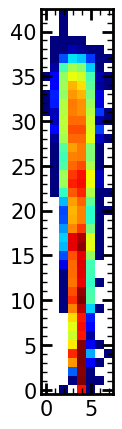

In [56]:
# list_muonlabels = [10, 15, 74, 91, 92, 112, 133, 176, 196, 256]  # Segunda revisión (están arriba)
# list_muonlabels = [10, 15, 91, 112, 176, 196, 256] # Tercera revisión (con misma gain = 215)

n_label = 130
display(DF_muons.iloc[[n_label]])

figure , axs = plt.subplots(1,1,figsize=[5,5])
# axs.imshow(list_mask_rot[n_label],  cmap = ColorMap, norm=Norm)  # 77, 1911, 2381, 2930 indices para path con elip 0.85, Sol 0.7
axs.imshow(list_datamask[n_label],  cmap = ColorMap, norm=Norm)  # 77, 1911, 2381, 2930 indices para path con elip 0.85, Sol 0.7
plt.show()


In [50]:
list_index_long_muons = []
extension = 1

for index in range(0, len(list_mask_rot)):
    size_x = list_mask_rot[index].shape[1]
    size_y = list_mask_rot[index].shape[0]
    if size_y > 50:
        # print(size_x, size_y)
        list_index_long_muons.append(index)

# print(list_index_long_muons)+
print('Muones largos detectados: ', len(list_index_long_muons))
print('Indices: ', list_index_long_muons)

Muones largos detectados:  76
Indices:  [2, 6, 7, 9, 10, 11, 15, 19, 23, 26, 30, 31, 38, 40, 50, 51, 75, 83, 89, 90, 91, 92, 93, 104, 105, 107, 109, 110, 118, 123, 128, 129, 139, 140, 154, 155, 156, 157, 159, 161, 162, 164, 171, 175, 191, 199, 200, 205, 211, 217, 222, 224, 228, 229, 237, 240, 241, 243, 272, 277, 283, 291, 306, 307, 309, 314, 315, 320, 323, 326, 327, 331, 333, 336, 344, 346]


### Perfil energético

Number of rows:  42


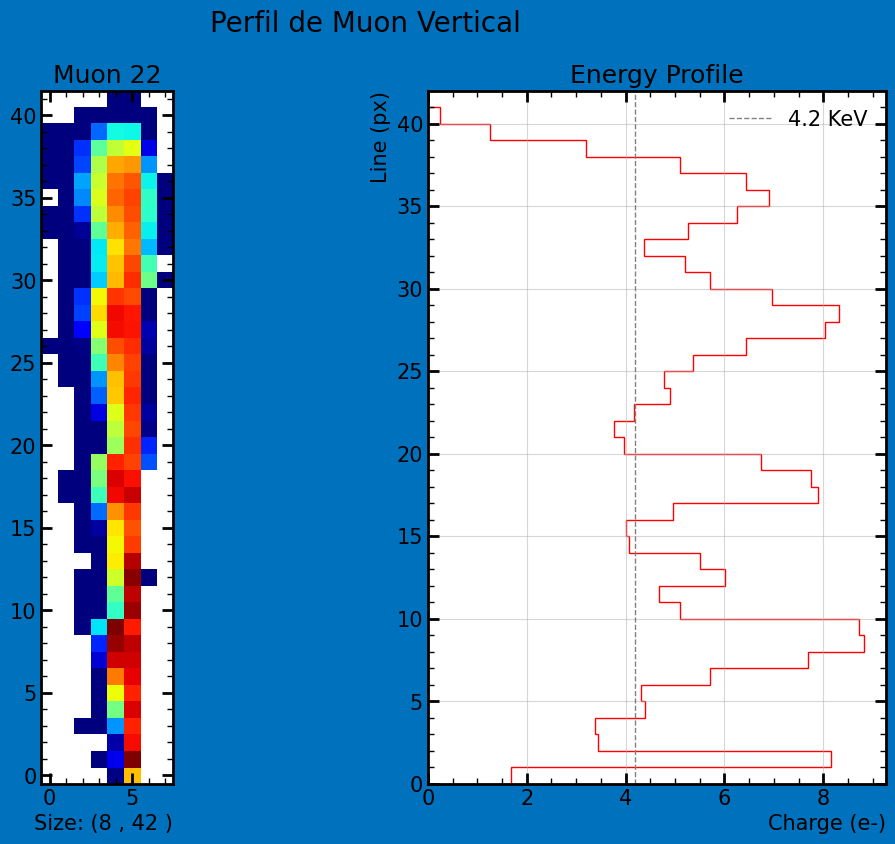

In [58]:
# list_muonlabels = [10, 15, 74, 91, 92, 112, 133, 176, 196, 256]  # Segunda revisión (están arriba)
muon_label = 22  # Se coloca directamente el label del evento

Delta_inicial = 0
Delta_final = 0
extension = 1

fig, axs = plt.subplots(ncols=2, nrows=1, figsize = [13,9], facecolor = [0, 0.4470, 0.7410])
fig.suptitle('Perfil de Muon Vertical', y = 0.97, size = 20)
event = list_mask_rot[muon_label]
# event = list_datamask[muon_label]
# plt.imshow(event)

size_x = event.shape[1] # tamaño en x
size_y = event.shape[0] # tamaño en y
# print(event.sum())

print('Number of rows: ', event.shape[0])
charge_verticalMuon = []
for index in range(1, size_y):
    line = event[index - 1:index][0]
    charge = line.sum()
    charge_verticalMuon.append(charge)

        
# cmap = 'plasma'
axs[0].imshow(event, cmap = ColorMap, norm = Norm)#, origin='upper')
axs[0].set_title('Muon ' + str(muon_label))
axs[0].set_xlabel('Size: (' + str(size_x) + ' , ' + str(size_y) + ' )')
# x0bar = fig.colorbar(x0, ax=axs[0])

axs[1].stairs(charge_verticalMuon, range(0,len(charge_verticalMuon)+1),  orientation='horizontal', color = 'r')#,  hatch = '////')
axs[1].axvline(4.2, 0, size_y+2, linestyle='--', color='gray', label = '4.2 KeV')
# axs[1].vlines(x = mean_charge, ymin = 0, ymax = len(event) - 1, color = 'k', label = 'Mean Charge \n' + str(mean_charge))

axs[1].set_ylim(0, size_y)
# axs[1].set_xlim(0, 4000)


# axs[1].set_xlabel('Charge (KeV)')
axs[1].set_xlabel('Charge (e-)')
axs[1].set_ylabel('Line (px)')
# axs[1].set_ylim(0,len(event) - 1 )
axs[1].set_title('Energy Profile')
axs[1].legend()
axs[1].grid()
plt.show()

### Modelo de Diff

/tmp/ipykernel_10433/530392281.py:134: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs_all.legend()


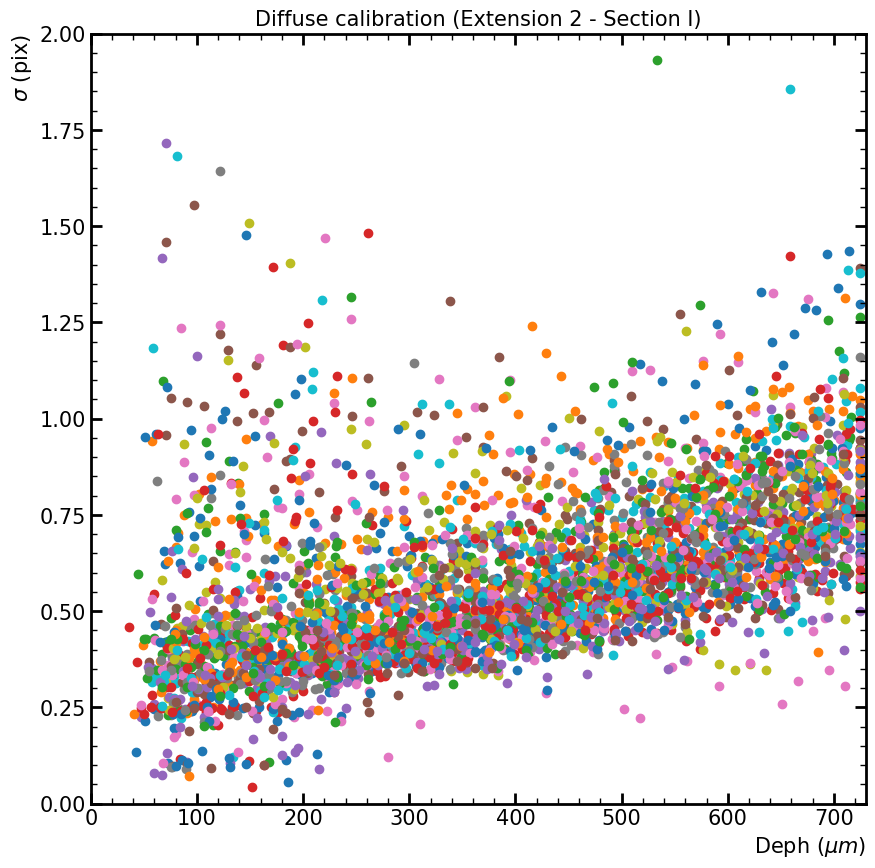

In [106]:
CCD_depth = 725 # micras
Delta_inicial = 5    # px
Delta_final = 6     # px
Bins = 50

extension = 2
img_sigma = 0.0008  # KeV 
# print(img_sigma)
fig, axs_all = plt.subplots(figsize = [10,10])

list_muonlabels = []
for index in range(0, len(list_mask_rot)):
    list_muonlabels.append(index)

# list_muonlabels = [256, 257, 258]

list_muonlabels = [2, 6, 7, 9, 10, 11, 15, 19, 23, 26, 30, 31, 38, 40, 50, 51, 75, 83, 89, 90, 91, 92, 93, 104, 105, 107, 
                   109, 110, 118, 123, 128, 129, 139, 140, 154, 155, 156, 157, 159, 161, 162, 164, 171, 175, 191, 199, 200, 
                   205, 211, 217, 222, 224, 228, 229, 237, 240, 241, 243, 272, 277, 283, 291, 306, 307, 309, 314, 315, 320, 
                   323, 326, 327, 331, 333, 336, 344, 346]

# list_muonlabels = [26, 224, 323]

for label_muon in list_muonlabels: 
    event = list_mask_rot[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_y 
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []
    for lable_line in range(Delta_inicial, size_y - Delta_final):
        line = event[lable_line - 1:lable_line][0]
        Carga_renglon = line.sum()
        Mean_carga = np.mean(line)
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel]:
                element_pixel = (pixel * line[pixel]) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel = line[pixel]**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel]
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        # var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var_true)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

        for index in range(0, len(line)):
            if line[index] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index])
                h3.SetBinError(index + 1, img_sigma)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQN")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)

    # axs_all.scatter(list_deep, list_fitsigmas, label = 'Muon: ' + str(label_muon))
    axs_all.scatter(list_deep, list_fitsigmas)


def diffution_curve(z, alpha, beta):
    return np.sqrt((alpha * np.log(1 - (beta * z))))

fit_range = np.arange(0, 725)

# axs_all.plot(fit_range, diffution_curve(fit_range, alpha=-200, beta=0.001) / 15, '--r', linewidth = 3)

axs_all.set_title('Diffuse calibration (Extension 2 - Section I)', size = 15)#, y=0.92)}
axs_all.set_ylabel(r'$\sigma$ (pix)')
axs_all.set_xlabel(r'Deph ($\mu m$)')
axs_all.set_ylim(0, 2)
axs_all.set_xlim(0, 730)
axs_all.legend()
axs_all.grid
plt.show()

/tmp/ipykernel_10433/2236501758.py:138: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs_all.legend()


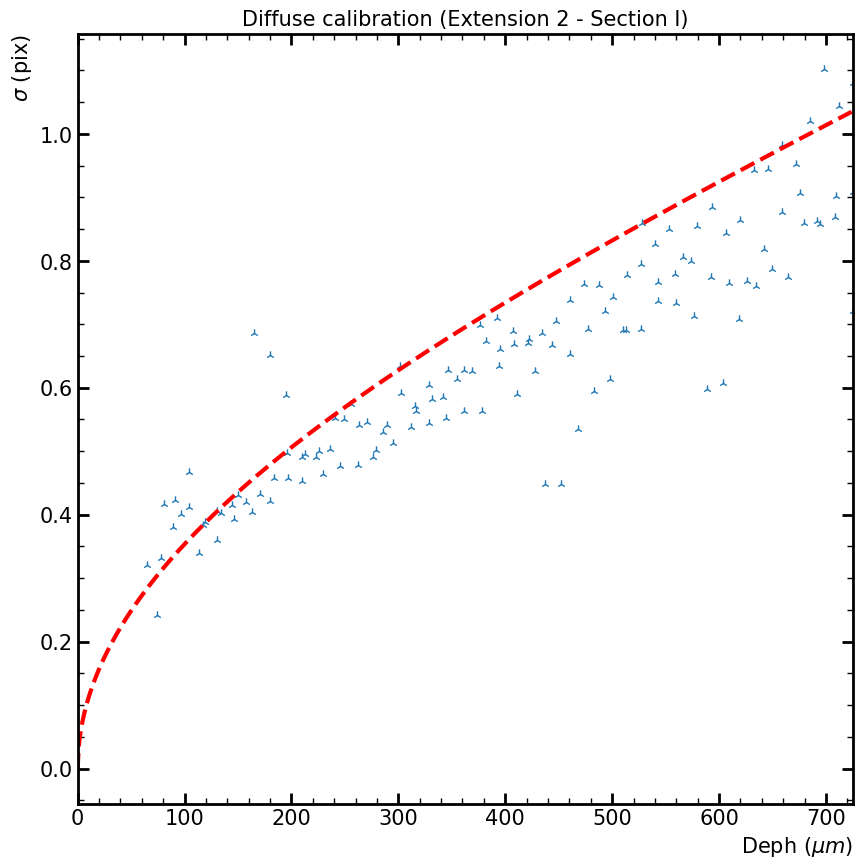

In [101]:
img_sigma = 0.0008  # KeV 
# print(img_sigma)
fig, axs_all = plt.subplots(figsize = [10,10])

# list_muonlabels = [256, 257, 258]

list_all_sigmas = []
list_all_deeps = []

for label_muon in list_muonlabels: 
    event = list_mask_rot[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_y 
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []

    for lable_line in range(Delta_inicial, size_y - Delta_final):
        line = event[lable_line - 1:lable_line][0]
        Carga_renglon = line.sum()
        Mean_carga = np.mean(line)
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel]:
                element_pixel = (pixel * line[pixel]) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel = line[pixel]**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel]
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        # var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

        for index in range(0, len(line)):
            if line[index] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index])
                h3.SetBinError(index + 1, img_sigma)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQN")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)


    for index in range(0, len(list_fitsigmas)):
        list_all_sigmas.append(list_fitsigmas[index])
        list_all_deeps.append(list_deep[index])

    # axs_all.scatter(list_deep, list_fitsigmas, marker='2', label = 'Muon: ' + str(label_muon))
del list_fitsigmas
del list_deep


fit_range = np.arange(0, 725)



axs_all.scatter(list_all_deeps, list_all_sigmas, marker='2')

def diffution_curve(x, alpha, beta):
    return np.sqrt((alpha * np.log(1 - (beta * x))))

# popt_DM, _ = curve_fit(diffution_curve, list_all_deeps, list_all_sigmas, maxfev=100000, p0= [1, 1])
# dict_diffution_model = {'Alpha' : popt_DM[0], 'Beta' : popt_DM[1]}
# print('Alpha: ', dict_diffution_model['Alpha'], ' Beta: ', dict_diffution_model['Beta'])




axs_all.plot(fit_range, diffution_curve(fit_range, -611, 0.00045)/15, '--r', linewidth = 3)

axs_all.set_title('Diffuse calibration (Extension 2 - Section I)', size = 15)#, y=0.92)}
axs_all.set_ylabel(r'$\sigma$ (pix)')
axs_all.set_xlabel(r'Deph ($\mu m$)')
# axs_all.set_ylim(0, 1.5)
axs_all.set_xlim(0, 725)
axs_all.legend()
axs_all.grid
plt.show()

In [102]:
list_all_sigmas = []
list_all_deeps = []

for label_muon in list_muonlabels: 
    event = list_mask_rot[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_y 
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []

    for lable_line in range(Delta_inicial, size_y - Delta_final):
        line = event[lable_line - 1:lable_line][0]
        Carga_renglon = line.sum()
        Mean_carga = np.mean(line)
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel]:
                element_pixel = (pixel * line[pixel]) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel = line[pixel]**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel]
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        # var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)


        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

        for index in range(0, len(line)):
            if line[index] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index])
                h3.SetBinError(index + 1, img_sigma)
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQN")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)

        del h3

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)


    for index in range(0, len(list_fitsigmas)):
        list_all_sigmas.append(list_fitsigmas[index])
        list_all_deeps.append(list_deep[index])

    # axs_all.scatter(list_deep, list_fitsigmas, marker='2', label = 'Muon: ' + str(label_muon))
del list_fitsigmas
del list_deep



# fit_range = np.arange(0, 900)
# axs_all.scatter(list_all_deeps, list_all_sigmas, marker='2')
 
h_model = TGraph(len(list_all_sigmas), np.array(list_all_deeps),np.array(list_all_sigmas))
h_model.SetMarkerStyle(2) # Set marker style (e.g., solid circle)
h_model.SetName("Data")
h_model.SetStats()



Range_fit = [0, 725]
diff_curve = TF1("diff_curve", "sqrt(([0] * log(1 - [1]*x)))/15", Range_fit[0], Range_fit[1], 2) #np.sqrt(np.abs(alpha * np.log(1 - (beta * z))))

diff_curve.SetParameters(-200, 0.00001) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h_model.Fit(diff_curve, "RNQ")

fit_alpha = diff_curve.GetParameters()[0]
fit_beta = diff_curve.GetParameters()[1]
chi2 = diff_curve.GetChisquare()
ndf = diff_curve.GetNDF()
prob = diff_curve.GetProb()

fit_alpha_err = diff_curve.GetParErrors()[0]
fit_beta_err = diff_curve.GetParErrors()[1]

print('Alpha: ', fit_alpha, '+- ', fit_alpha_err) 
print('Beta: ', fit_beta,  '+- ', fit_beta_err)
print('Chi2/ndf: ', chi2, '/', ndf)
print('Prob: ', prob)


# marco=TH1F("marco", "Diffusion Model", 100, 0, 725)


c3=TCanvas()
# marco.Draw("same")
h_model.Draw("AP same")
diff_curve.Draw("same")
c3.Draw()

# axs_all.plot(fit_range, diffution_curve(fit_range, *popt_DM), '--r', linewidth = 3)

# axs_all.set_title('Diffuse calibration (Extension 1 - Section I)', size = 15)#, y=0.92)}
# axs_all.set_ylabel(r'$\sigma$ (pix)')
# axs_all.set_xlabel(r'Deph ($\mu m$)')
# axs_all.set_ylim(0, 1.5)
# axs_all.set_xlim(0, 725)
# axs_all.legend()
# axs_all.grid
# plt.show()

Alpha:  -3362.493695899484 +-  2115.596982583699
Beta:  7.143855409745954e-05 +-  4.414277242340068e-05
Chi2/ndf:  0.8582891532213017 / 133
Prob:  1.0
